# **Introduction**

The goal of this practical exercise is to implement and train a multi-layer perceptron with sine activation functions (SIREN), which is well suited to encode shapes as signed-distance-functions.

This exercise is based on the paper *Implicit Neural Representations
with Periodic Activation Functions*, https://vsitzmann.github.io/siren/

To achieve this goal, we will first target a simple scenario where the signed-distance-function (SDF) is known over the domain, and just needs to be encoded by the network.

Then, we will consider a more challenging scenario where the SDF is only known at the boundary of a shape, i.e. where it equals zero. This scenario corresponds to the real-world case where an object is scanned in the form of a point cloud, and one wants to interpolate the points to form a closed surface.

Note that the first part of the exercise can be done **using CPU only**. You only need to connect to an environment with GPU execution for the second and third part (training).



# **Part 1 - Generating a Signed Distance Function (SDF)**

The goal of this part is to generate and display a simple signed-distance function.

First, let's load the packages we will need.

In [ ]:
import torch
from torch import nn

from matplotlib import pyplot as plt
import matplotlib

import numpy as np
import math

from google.colab import widgets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Next, we define a class representing a spherical SDF (a disk in 2D).

**Q1.(2pts)** Implement the function **forward(self,p)** that returns, for each 2D point in **p**, its distance to the boundary of a sphere. The sphere is defined by its center **(cx,cy)** and radius **r**.

In [ ]:
class SphereSDF(nn.Module):
  def __init__(self, cx, cy, r):
    super().__init__()
    self.cx, self.cy, self.r = cx, cy, r

  def forward(self, p):
    # Q1. Return, for the 2D point p, its distance to the boundary of a sphere of radius r, centered at (cx,cy)
    return torch.sqrt((p[:,0] - self.cx)**2 + (p[:,1] - self.cy)**2) - self.r
    

Test the function on two points, one on the sphere and one away from it. With the values below, you should obtain a distance of 0 for the first point and 5 for the second.

In [ ]:
sphereTest = SphereSDF(0,0,10)
pts = torch.tensor([[0,10],[0,15]])
sphereTest(pts)

tensor([0., 5.])

We will now define a function that displays the SDF sampled over a regular grid.

In [ ]:
def display_sdfGray(f, resolution):

    """
    displays the values of the function f, evaluated over a regular grid defined between -1 and 1 and of resolution (resolution x resolution)
    """

    # First, construct a grid where each cell stores its coordinates
    # sampling of 'x' coordinates
    x = torch.linspace(-1, 1, resolution, device = device)

    # sampling of x and y coordinates:
    xy = [x]*2 #equivalent to [x, x]

    # pair of (resolution x resolution tensor), one for the 'x' coordinates of the point of the grid, one for the y coordinates
    X, Y = torch.meshgrid(xy, indexing = 'xy')

    # stack X and Y. Note how stack is different from cat: stack creates a new axis, here 2
    # finally, 'reshape' change the shape of the tensor from  (resolution, resolution, 2) to (resolution², 2). We use -1 to let pytorch compute what resolution² should be.
    coords = torch.stack([X, Y], dim=2).reshape(-1, 2)

    # compute the sdf and reshape it to the dimension of the final image
    sdf = f(coords).reshape(resolution, resolution)
    
    # fetch the sdf tensor from the GPU and convert it to numpy array
    numpy_sdf = sdf.detach().cpu().numpy()

    # display sdf as a graylevel image by copying its values in all three color channels
    plt.imshow(np.concatenate([numpy_sdf[:,:,np.newaxis],numpy_sdf[:,:,np.newaxis],numpy_sdf[:,:,np.newaxis]], axis = 2) )
    plt.show()

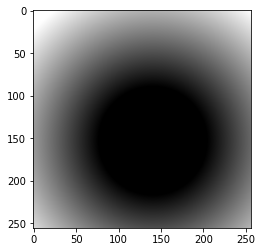

In [ ]:
display_sdfGray(SphereSDF(.1, .2, .5), 256)

**Q2.(3pts)** Extend the function to display positive values of the SDF in red, negative values in blue, and white in-between. Display the zero-levelset (i.e. values close to 0) in black. The expected result is:

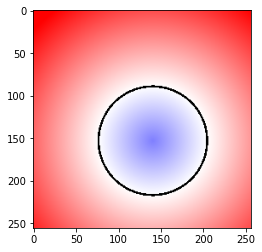

In [ ]:
def display_sdfColor(f, resolution):

    """
    displays the values of the function f, evaluated over a regular grid defined between -1 and 1 and of resolution (resolution x resolution)
    """

    # First, construct a grid where each cell stores its coordinates
    # sampling of 'x' coordinates
    x = torch.linspace(-1, 1, resolution, device = device)

    # sampling of x and y coordinates:
    xy = [x]*2 #equivalent to [x, x]

    # pair of (resolution x resolution tensor), one for the 'x' coordinates of the point of the grid, one for the y coordinates
    X, Y = torch.meshgrid(xy, indexing = 'xy')

    # stack X and Y. Note how stack is different from cat: stack creates a new axis, here 2
    # finally, 'reshape' change the shape of the tensor from  (resolution, resolution, 2) to (resolution², 2). We use -1 to let pytorch compute what resolution² should be.
    coords = torch.stack([X, Y], dim=2).reshape(-1, 2)

    # compute the sdf and reshape it to the dimension of the final image
    sdf = f(coords).reshape(resolution, resolution)

    # fetch the sdf tensor from the GPU and convert it to numpy array
    numpy_sdf = sdf.detach().cpu().numpy()
    print(numpy_sdf.size)
    # Q2. Display positive values of the SDF in red, negative values in blue, and white in-between. Display the zero-levelset in black
    cmap = matplotlib.cm.get_cmap('bwr')
    # I tried many different things but I didn't manage to change the color of the zero value to black. 
    #cmap.set_bad(color='black')
    plt.imshow(numpy_sdf, cmap=cmap)
    
    plt.show()


65536


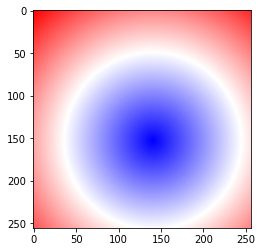

In [ ]:
display_sdfColor(SphereSDF(.1, .2, .5), 256)

It is also informative to compute and display the norm of the gradient of the SDF, as in theory it should always be equal to 1. Fortunately, we can use PyTorch's automatic differentiation to compute the gradient:

In [ ]:
# Compute gradient of output y with respect to input x
def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

We next provide a function to display the gradient norm, this time using a pre-defined color map:

In [ ]:
def display_grad(f, resolution):
    """
    displays the norm of the gradient of the function f, evaluated at points of a regular grid defined between -1 and 1 and of resolution (resolution x resolution)
    """
    # This single line is equivalent to the 4 first lines of the previous function
    coords = torch.stack(list(torch.meshgrid([torch.linspace(-1, 1, resolution, device = device)]*2, indexing = 'xy')), dim=2).reshape(-1, 2)
    # we need to initialize the gradient to later compute the gradients of the function depending on the corrdinates 
    coords.requires_grad = True
    # compute the function, the gradient, its norm, send the result to the CPU, and reshape to the image size
    sdf = f(coords)
    grad = gradient(sdf, coords).norm(dim = 1).detach().cpu().numpy().reshape(resolution, resolution)
    
    #plot the gradient norm, with 'plasma' colormap, and automatic normalization to map [0, 2] to [0, 1]
    plt.imshow(grad, cmap = "plasma", vmin = 0, vmax = 2)
    plt.colorbar()
    plt.show()

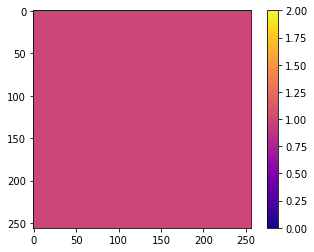

In [ ]:
display_grad(SphereSDF(.1, .2, .5), 256)

# **Part 2 - Implementing a SIREN neural network**

The goal of this part is to implement a multi-layer perceptron with sine activation functions -- also called a SIREN (https://vsitzmann.github.io/siren/) -- and train the nerwork to encode the SDF.

We will first implement a single activation function, then a network layer, and finally the multi-layer neural network.

**Q3. (1pts)** Implement **forward(self,x)** to be a sine function **y = sine(w0*x)**

In [ ]:
class Sine(nn.Module):
    def __init__(self, w0 = 30.):
        super().__init__()
        self.w0 = w0 
    def forward(self, x):
        #Q3. Implement a sine activation function
        return torch.sin(self.w0*x)

Test that your function effectively produces a sinusoid:

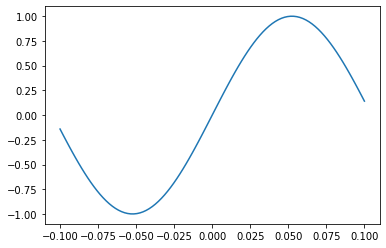

In [ ]:
x = torch.linspace(-0.1,0.1,100)
sineActivation = Sine()
y = sineActivation(x)
plt.plot(x,y)

**Q4. (2pts)** Next, we impement a SIREN layer. Implement **forward(self, x)** to compute the output as a linear transformation of the input (**y = weights * x + bias**), followed by the activation function. See https://pytorch.org/docs/stable/nn.functional.html for a list of helpful PyTorch operations, including the linear transformation.

In [ ]:
#siren layer
class SirenLayer(nn.Module):
    def __init__(self, dim_in, dim_out, w0 = 1., c = 6., is_first = False, use_bias = True, activation = None):
        super().__init__()
        self.dim_in = dim_in
        self.is_first = is_first

        weight = torch.zeros(dim_out, dim_in)
        bias = torch.zeros(dim_out) if use_bias else None
        self.init_(weight, bias, c = c, w0 = w0)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(bias) if use_bias else None
        self.activation = Sine(w0) if activation is None else activation

    # weight initialization (see Seection 3.2 of the original paper)
    def init_(self, weight, bias, c, w0):
        dim = self.dim_in

        w_std = (1 / dim) if self.is_first else (math.sqrt(c / dim) / w0)
        weight.uniform_(-w_std, w_std)

        if bias is not None:
            bias.uniform_(-w_std, w_std)

    def forward(self, x):
        # Q4. Compute the output as a linear transformation of the input (y = weights * x + bias), followed by the activation function
        return self.activation(torch.nn.functional.linear(x, self.weight, self.bias))

And finally, we can implement the SIREN neural network

In [ ]:
# siren network
class SirenNet(nn.Module):
    # change from the original implementation: w0 = 30 instead of 1, use_bias is always true, final_activation is always Identity, but we add an option to change the activation of all inner layers (sine by default)
    # num_layers counts: input + hidden layers (not output)
    def __init__(self, dim_in, dim_hidden, dim_out, num_layers, w0 = 1., w0_initial = 30., activation = None): 
        super().__init__()
        self.num_layers = num_layers
        self.dim_hidden = dim_hidden

        self.layers = nn.ModuleList([])
        for ind in range(num_layers):
            is_first = ind == 0
            layer_w0 = w0_initial if is_first else w0
            layer_dim_in = dim_in if is_first else dim_hidden

            self.layers.append(SirenLayer(
                dim_in = layer_dim_in,
                dim_out = dim_hidden,
                w0 = layer_w0,
                use_bias = True,
                is_first = is_first,
                activation = activation
            ))

        self.last_layer = SirenLayer(dim_in = dim_hidden, dim_out = dim_out, w0 = w0, use_bias = True, activation = nn.Identity())

    def forward(self, x):

        for layer in self.layers:
            x = layer(x)

        return self.last_layer(x)

**Q5. (4pts)** We are now ready to train the SIREN network to encode the SDF. To do so, implement: 
*  A MSE loss to encourage the network to output values close to the ground-truth SDF
*  A L1 loss to encourage the norm of the gradient to be close to one

We will then test this network with different combinations of losses, and compare it to a network that relies on ReLU activations.

**It is better to switch to an execution environment with GPU to speed up this part!**


In [ ]:
def encodeSDF(alpha, activation = None):

  # Used to display figures over a 2x2 grid
  grid = widgets.Grid(2,2)

  #bakup lists to store and display the loss
  ll, lg = [], []

  net  = SirenNet(
      dim_in = 2,                        # input dimension, in our case 2d coordinates
      dim_hidden = 128,                  # hidden dimension
      dim_out = 1,                       # output dimension, in our case a scalar corresponding to the distance to the shape
      num_layers = 4,                    # number of layers
      w0_initial = 30.,                   # different signals may require different omega_0 in the first layer - this is a hyperparameter
      w0 = 1 , #note: if we use w0 = 30 as in the original Siren implementation, it converges much faster, and the interest for the gradient loss is less clear. It seems less stable during optimization, though.  
      activation = activation
  ).to(device)
  optim = torch.optim.Adam(lr=1e-4, params=net.parameters(), )  

  # Train Siren
  for i in range(10): #iterations to see progress
    for k in range(300): #epoch

      # samples points randomly in the domain
      pts = torch.rand(1000, 2, dtype= torch.float, requires_grad=True, device = device)*2-1

      # compute the network output for these points
      out = net(pts)
      #compute the gradient of the output wrt the input points coordinates
      grad = gradient(out, pts)

      # get the ground truth sdf for these points
      gt = SphereSDF(.1, .2, .5)(pts)
      # clean the gradient graph
      optim.zero_grad()

      # Q5. MSE loss to encourage the output to be close to the ground thruth
      loss_func1 = torch.nn.MSELoss()
      loss_mse = loss_func1(out.squeeze(-1), gt)

      # Q5. Loss that penalizes gradients with a norm different from 1
      loss_func2 = torch.nn.L1Loss()
      loss_grad = loss_func2(torch.norm(grad, dim=1), torch.ones(grad.shape[0], device = device))

      # backup the values of the losses in external lists
      ll.append(loss_mse.item())
      lg.append(loss_grad.item())

      # weighted sum of the loss. alpha = .01 works best in practice for these hyperparameters
      loss = loss_mse + alpha * loss_grad

      # backpropagate the gradients
      loss.backward()
      
      # update the weights
      optim.step()


    # displays, could be converted to matlotlib
    # the advantage of this one is the 'clear_cell' function that allows for a progressive display of the improvements of the results
    with grid.output_to(0, 0):
      grid.clear_cell()
      plt.figure(figsize=(5, 5))
      display_sdfColor(net, 256)

    with grid.output_to(0, 1):
      grid.clear_cell()
      plt.figure(figsize=(5, 5))
      display_grad(net, 256)

    with grid.output_to(1, 0):
      grid.clear_cell()
      plt.yscale('log')
      plt.plot(ll, label = f'MSE loss ({ll[-1]})')
      plt.legend()
    
    with grid.output_to(1, 1):
      grid.clear_cell()
      plt.yscale('log')
      plt.plot(lg, label = f'grad loss ({lg[-1]})')
      plt.legend()

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

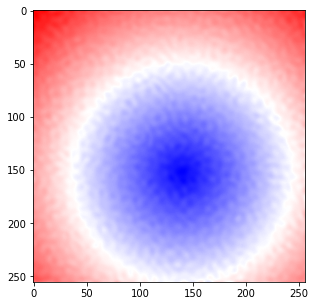

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

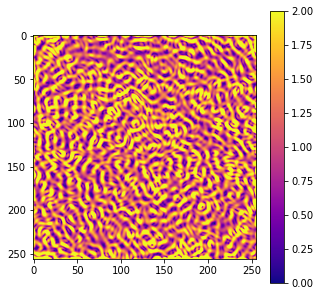

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

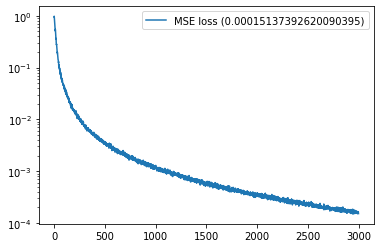

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

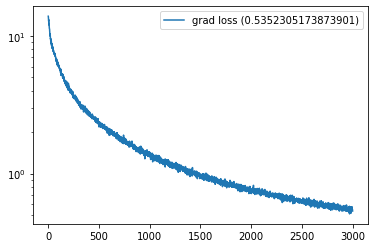

<IPython.core.display.Javascript object>

In [ ]:
# Train the network using only the MSE loss (alpha = 0)
encodeSDF(0)

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

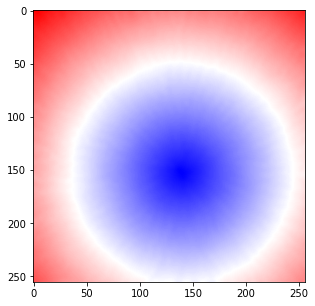

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

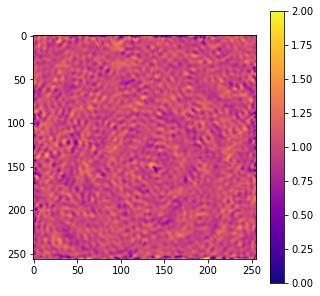

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

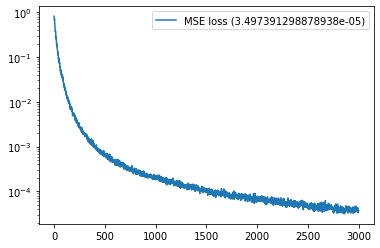

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

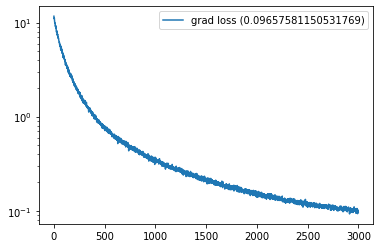

<IPython.core.display.Javascript object>

In [ ]:
# Train the network using both the MSE loss and the gradient loss (alpha = 0.01)
# The result should get smoother, and the gradient closer to 1
encodeSDF(0.01)

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

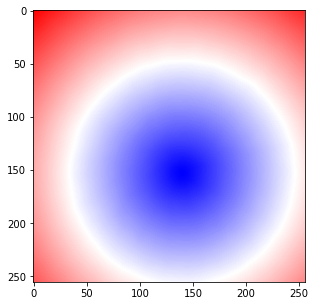

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

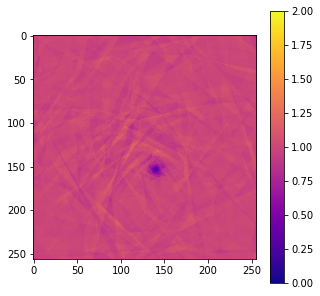

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

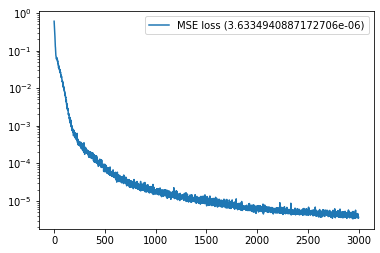

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

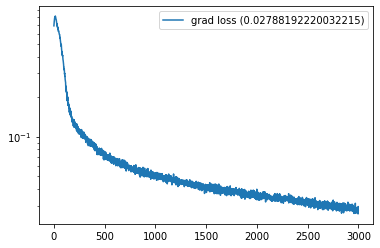

<IPython.core.display.Javascript object>

In [ ]:
# Train the network using a ReLU activation function. The result should look piecewise-smooth
encodeSDF(0.01,nn.functional.relu)

#**Part 3 - Fitting an SDF to a point cloud**

This third part targets a practical application of SIREN, which is to interpolate a surface over a point cloud. This is a common problem in geometry processing, as several technologies exist to scan oriented point clouds of real-world objects (using laser scanners, or photometric stereovision algorithms). A popular approach to solve this problem consists in fitting the zero levelset of an implicit function over the point cloud, as popularized by Kazhdan et al. in 2006, https://hhoppe.com/poissonrecon.pdf 

First, let's create an oriented point cloud:

In [ ]:
def square_point_cloud(x, y, c, pts_per_side, device):
    """
    Creates a set of points at the surface of a square, centered at x, y and side 'c'
    Each side will hold pts_per_side points
    """

    # sampling of points in [0,1]², stored in a tensor of size (pts_per_side, number_of_sides = 4, number_of_coordinates = 2)
    pts = torch.rand((pts_per_side, 4, 2))
    # modify the points so that they lie on the suqre of size 'c', centered at 0. 
    # note the use of boradcasting to ensure that points that belongs to different side get moved corrclty along this side
    pts = pts * torch.tensor([[[c, 0], [0, c], [c, 0], [0, c]]]) + .5 * c * torch.tensor([[[-1, 1], [1, -1], [-1, -1], [-1, -1]]]) 
    # shift the points so that the suqre is centered at x, y
    pts = pts + torch.tensor([[[x, y]]])

    # we also use broadcasting to compute the normals, depending on the side of the square
    normals = torch.ones_like(pts) * torch.tensor([[[0, 1], [1, 0], [0, -1], [-1, 0]]])
    
    # reshape from (points_per_side, 4, 2) to (total_number of points, 2), and send to GPU
    return pts.reshape(-1, 2).to(device), normals.reshape(-1, 2).to(device)

We also provide code to visualize this point cloud and its normals:

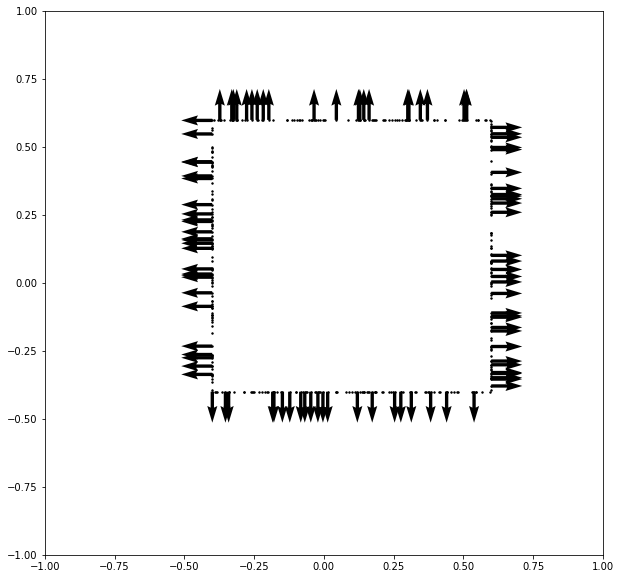

In [ ]:
pc = square_point_cloud(.1, .1, 1, 100, device)

pp = pc[0].detach().cpu()
pn = pc[1].detach().cpu()

plt.figure(figsize=(10, 10))
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.scatter(pp[:, 0], pp[:, 1], s = 2, color = 'black')
randomstate = np.random.default_rng(0)
#select a subset to display arrows
ii = randomstate.choice(pp.shape[0], 100, replace=False, shuffle=True )
plt.quiver(pp[ii, 0], pp[ii, 1], pn[ii, 0], pn[ii, 1], angles='xy', units = 'xy');

**Q6.(4pts)** The main idea of the method is to constrain the SDF:
*   To be equal to zero on the point cloud
*   To be different from zero away from the point cloud
*   To have a gradient aligned with the normal of the points on the point cloud
*   To have a gradient norm close to one everywhere, including on points away from the point cloud

As a first step, implement the following loss functions, described in Section 4.2 of the SIREN paper (https://arxiv.org/pdf/2006.09661.pdf)




In [ ]:
# Q6. loss to constrain the gradient norm to be close 1 (same as above). This loss will be applied to all points of the domain.
def sdf_loss_gradNorm(grad):
    loss_gradNorm = torch.nn.L1Loss()
    return loss_gradNorm(torch.norm(grad, dim=1), torch.ones(grad.shape[0], device = device))
    

# Q6. loss to constrain the SDF to be close to 0. This loss will be only applied to points of the point cloud.
def sdf_loss_zero(sdf):
    loss_zero = torch.nn.L1Loss()
    return loss_zero(sdf.squeeze(-1), torch.zeros(sdf.shape[0], device=device))
    

# Q6. loss to align the SDF gradient to the point normals. This loss will be only applied to points of the point cloud.
def sdf_loss_align(grad, normals):
    loss_align = torch.nn.L1Loss()
    return loss_align(grad, normals)
    

# Q6. loss to encourage points away from the point cloud to have a SDF value different from zero (see \psi(x) in Equation 6 of the paper). This loss will be only applied to points away from the point cloud.
def sdf_loss_nonzero(sdf, alpha):
    loss_nonzero = torch.nn.L1Loss()
    return loss_nonzero(torch.exp(-alpha*torch.norm(sdf, dim=1)), torch.zeros(sdf.shape[0], device=device))
    

# loss for points on the point cloud
def sdf_loss_point_cloud(sdf, pts, normals):

    grad = gradient(sdf, pts)

    return (sdf_loss_zero(sdf) * 3e3 + #favor zero levelset, term is weighted by 3e3
            sdf_loss_align(grad, normals) * 1e2 + #favor alignment to point normals, term is weighted by 1e2
            sdf_loss_gradNorm(grad) * 5e1 ) #gradient norm should be close to one
    
# loss for points away from the point cloud    
def sdf_loss_others(sdf, pts):

    grad = gradient(sdf, pts)

    return (sdf_loss_nonzero(sdf, 1e2) * 1e2 #push away from 0, term is weighted by 1e2
             + sdf_loss_gradNorm(grad)  * 5e1  ) #gradient norm

We can now train the SIREN network with these losses

,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

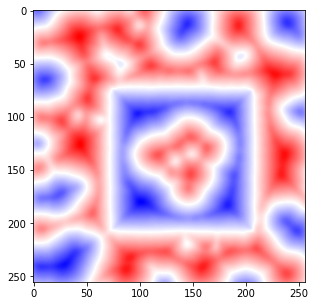

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

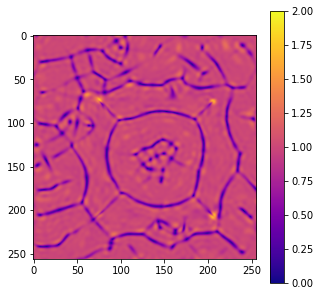

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

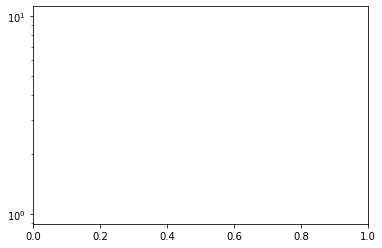

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
net = SirenNet(
    dim_in = 2,                        # input dimension, 2d coordinates
    dim_hidden = 256,                  # hidden dimension
    dim_out = 1,                       # output dimension, scalar distance value
    num_layers = 4,                    # number of layers
    w0_initial = 30.,                   # different signals may require different omega_0 in the first layer - this is a hyperparameter
    w0 = 30,
    ).to(device)

optim = torch.optim.Adam(lr=1e-4, params=net.parameters(), )  
    
# create the point cloud
pts_point_cloud, normal_point_clound = square_point_cloud(.1, .1, 1, 100, device)
pts_point_cloud.requires_grad = True

#bakup lists to store and display the loss
lpc, loth = [], []

# Used to display figures over a 2x2 grid
grid = widgets.Grid(1,3)

for batch in range(500):
    
    # randomly sampled point in the domain (100x more than the points in the point cloud)
    pts_random = torch.rand((pts_point_cloud.shape[0]*100, 2), device = device)*2-1
    pts_random.requires_grad = True

    #predict the sdf for all points
    pred_sdf_point_cloud = net(pts_point_cloud)
    pred_sdf_random = net(pts_random)

    # compute and store the losses
    loss_pc = sdf_loss_point_cloud(pred_sdf_point_cloud, pts_point_cloud, normal_point_clound)
    loss_other = sdf_loss_others(pred_sdf_random, pts_random)

    lpc.append(loss_pc)
    loth.append(loss_other)

    # sum the losses of reach of this set of points
    # note: for each of the set, the loss is averaged, 
    # which means that the loss for "pred_sdf_point_cloud" will have the same weigth as the one for "pred_sdf_random", 
    # even though there are 100 times more samples in the later
    loss = loss_pc + loss_other 
    optim.zero_grad()
    loss.backward()

    optim.step()

    # display the result each 20 batches 
    if batch%20 == 19:
        with grid.output_to(0, 0):
          grid.clear_cell()
          plt.figure(figsize=(5, 5))
          display_sdfColor(net, 256)

        with grid.output_to(0, 1):
          grid.clear_cell()
          plt.figure(figsize=(5, 5))
          display_grad(net, 256)

        with grid.output_to(0, 2):
          grid.clear_cell()
          plt.yscale('log')
          #plt.plot(lpc, label = f'Point cloud loss ({lpc[-1]})')
          #plt.plot(loth, label = f'Other points loss ({loth[-1]})')
          #plt.legend()

Unfortunately, the sparse point cloud does not provide enough constraints to achieve a smooth result. Away from the point cloud, the SDF oscillates between positive and negative values and does not reach a gradient norm of 1.

We will constrain the problem further by adding a few points away from the point cloud, and approximate the SDF at those points by computing the distance to the closest point on the point cloud.

**Q7. (3pts)** As a first step, implement a function to compute the signed distance of a set of points to the closest points of a point cloud. You can deduce the sign of the distance at each point (inside or outside the shape) by computing its orientation with respect to the closest point's normal.

In [ ]:
def dist_to_pc(pts, pc, grad):

    # compute distance between all point samples to all points of the cloud
    n = pts.shape[0]  # 100
    m = pc.shape[0]   # 400

    all_dist = torch.zeros(n, m)
    for i in range(n):
      all_dist[i] = torch.sqrt((pc[:,0] - pts[i,0])**2 + (pc[:,1] - pts[i,1])**2)

    # find for each sample point, index of closest point in the point cloud
    index_of_closest_points = torch.zeros(n)
    for i in range(n):
      index_of_closest_points[i] = torch.argmin(all_dist[i])
    indexes = index_of_closest_points.cpu().detach().numpy()
    indexes = indexes.astype('int32')

    dist = torch.zeros(n)
    for i in range(n):
        dist[i] = all_dist[i][indexes[i]]

    # find sign s, i.e. direction towards the point cloud (can be obtained by computing a dot product)
    directions = torch.zeros(n, 2)
    for i in range(n):
      directions[i] = pts[i] - pc[indexes[i]]

    grad_pts = torch.zeros(n, 2)
    for i in range(n):
      grad_pts[i] = grad[indexes[i]]

    product = torch.zeros(n)
    for i in range(n):
      product[i] = torch.dot(directions[i], grad_pts[i])
    s = torch.zeros(n)
    s = torch.where(product < 0,torch.tensor(-1), product)
    s = torch.where(product > 0,torch.tensor(1), product)
    
    return dist * s

We can test the function by displaying a few points around the point cloud, with a color map that displays positive distances in red and negative distances in blue:

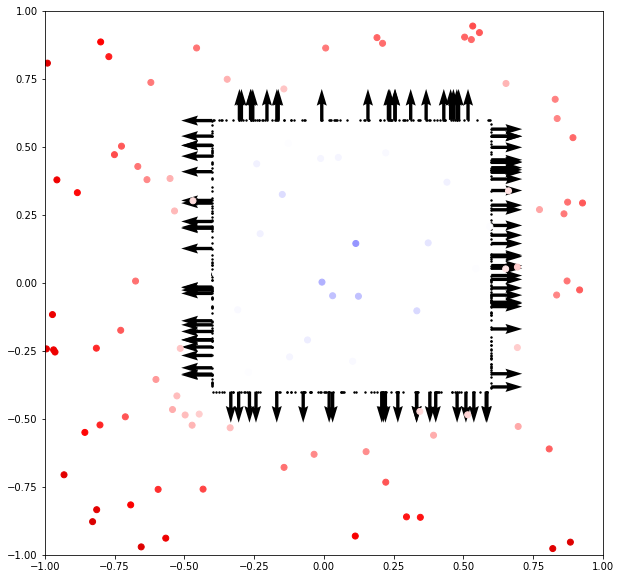

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

pc = square_point_cloud(.1, .1, 1, 100, device)

pp = pc[0].detach().cpu()
pn = pc[1].detach().cpu()

plt.figure(figsize=(10, 10))
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.scatter(pp[:, 0], pp[:, 1], s = 2, color = 'black')
randomstate = np.random.default_rng(0)
#select a subset to display arrows
ii = randomstate.choice(pp.shape[0], 100, replace=False, shuffle=True )
plt.quiver(pp[ii, 0], pp[ii, 1], pn[ii, 0], pn[ii, 1], angles='xy', units = 'xy');

pts = torch.rand((100, 2), device = device)*2-1
sdf = dist_to_pc(pts, pc[0], pc[1])
pts = pts.detach().cpu()
plt.scatter(pts[:, 0], pts[:, 1], c = sdf.detach().cpu(), cmap = 'seismic', vmin = -1, vmax = 1);

**Q8. (1pts)** Define a loss function that encourages the SDF to agree with a target value on a set of points

In [ ]:
# Q8. loss to encourage the SDF to take target values on a set of ground-truth points. WARNING: make sure that both sdf and pts have the same shape
def sdf_loss_target(sdf, pts, target_sdf):
  loss_func = torch.nn.L1Loss()
  return loss_func(sdf.squeeze(-1), target_sdf)
    
def sdf_loss_hints(sdf, pts, target_sdf):

    grad = gradient(sdf, pts)

    return ( sdf_loss_target(sdf, pts, target_sdf) * 3e3 +
            sdf_loss_gradNorm(grad)  * 5e1 )

We can now train the network with this additional loss

,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

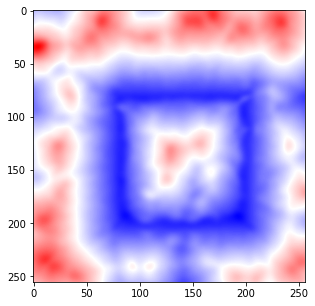

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

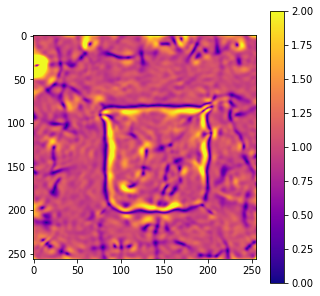

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

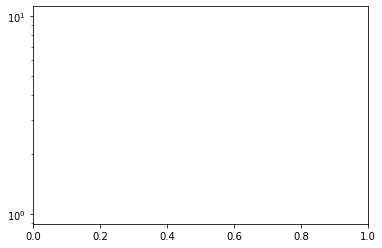

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
net = SirenNet(
    dim_in = 2,                        # input dimension, 2d coordinates
    dim_hidden = 256,                  # hidden dimension
    dim_out = 1,                       # output dimension, scalar distance value
    num_layers = 4,                    # number of layers
    w0_initial = 30.,                  # different signals may require different omega_0 in the first layer - this is a hyperparameter
    w0 = 30,
    ).to(device)

optim = torch.optim.Adam(lr=1e-4, params=net.parameters(), )  
    
# create the point cloud
pts_point_cloud, normal_point_clound = square_point_cloud(.1, .1, 1, 100, device)
pts_point_cloud.requires_grad = True

# add additional "hint points" at which we know the sdf 
pts_hint = torch.rand((100, 2), device = device)*2-1
pts_hint.requires_grad = True
gt_sdf_hint = dist_to_pc(pts_hint, pts_point_cloud, normal_point_clound).detach() # detach is needed to break the connection wetween the gound truth and the corresponding points in the gradient graph

#bakup lists to store and display the loss
lpc, loth, lh = [], [], []

# Used to display figures over a 2x2 grid
grid = widgets.Grid(1,3)

for batch in range(500):
    
    # randomly sampled point in the domain (100x more than the points in the point cloud)
    pts_random = torch.rand((pts_point_cloud.shape[0]*100, 2), device = device)*2-1
    pts_random.requires_grad = True

    #predict the sdf for all points
    pred_sdf_point_cloud = net(pts_point_cloud)
    pred_sdf_hint = net(pts_hint)
    pred_sdf_random = net(pts_random)

    # compute and store the losses
    loss_pc = sdf_loss_point_cloud(pred_sdf_point_cloud, pts_point_cloud, normal_point_clound, )
    loss_other = sdf_loss_others(pred_sdf_random, pts_random)
    loss_hint = sdf_loss_hints(pred_sdf_hint, pts_hint, gt_sdf_hint)

    lpc.append(loss_pc)
    loth.append(loss_other)
    lh.append(loss_hint)

    # sum the losses of reach of this set of points
    # note: for each of the set, the loss is averaged, 
    # which means that the loss for "pred_sdf_point_cloud" will have the same weigth as the one for "pred_sdf_random", 
    # even though there are 100 times more samples in the later
    loss = loss_pc + loss_other + loss_hint
    optim.zero_grad()
    loss.backward()

    optim.step()

    # display the result each 20 batches 
    if batch%20 == 19:
        with grid.output_to(0, 0):
          grid.clear_cell()
          plt.figure(figsize=(5, 5))
          display_sdfColor(net, 256)

        with grid.output_to(0, 1):
          grid.clear_cell()
          plt.figure(figsize=(5, 5))
          display_grad(net, 256)

        with grid.output_to(0, 2):
          grid.clear_cell()
          plt.yscale('log')
          #plt.plot(lpc, label = f'Point cloud loss ({lpc[-1]})')
          #plt.plot(loth, label = f'Other points loss ({loth[-1]})')
          #plt.plot(lh, label = f'Hint points loss ({lh[-1]})')
          #plt.legend()

#**Possible extensions**

**3D point clouds**

A natural extension of this exercise is to fit an implicit surface over a 3D point cloud. In addition to extending the functions above, you will need a way to display the zero-levelset of the function as a 3D surface. 

To do so, you can extract a triangle mesh of the zero-levelset using the marching cube algorithm [1,2]. Converting the implicit surface to a mesh can then allow you to process the surface, as described below.

You can test your code on simple analytic SDFs [3], or by loading 3D meshes and treating their vertices as a point cloud [4].

**Mesh smoothing**

Using marching cube to extract a 3D mesh of the zero-levelset [2], you can try to implement the algorithm by Mehta et al. [5] that processes an implicit surface by alternatively extracting the mesh, smoothing it using an existing mesh-based algorithm, and updating the implicit function to fit the smoothed mesh. Trimesh provides several implementations of Laplacian smoothing for 3D meshes [6].

**Regularization**

In the last part of the exercise, we have added a set of points around the shape to regularize the fitting of the SDF. More advanced strategies have been proposed, such as Iso-Points [7].

The neural network can also be encouraged to produce smooth solutions by regularizing its weights [8]. This simple trick also stabilizes shape interpolation, which you could try by training the neural network to fit two different shapes conditioned on a binary code (say 0 = sphere, 1 = cube), and then testing the network with code values between 0 and 1 (see the referenced paper for such examples).

**References**

[1] Marching cubes: A high resolution 3d surface construction algorithm

Lorensen, W. E.; Cline, Harvey E. (1987)

https://en.wikipedia.org/wiki/Marching_cubes

[2] Marching cubes in Scikit-image

https://scikit-image.org/docs/stable/auto_examples/edges/plot_marching_cubes.html

[3] SDFs of simple shapes

https://iquilezles.org/articles/distfunctions/

[4] Loading a 3D mesh using Trimesh

https://colab.research.google.com/github/tensorflow/graphics/blob/master/tensorflow_graphics/g3doc/_index.ipynb#scrollTo=XUmNqU4FJm-Y

[5] A Level Set Theory for Neural Implicit Evolution under Explicit Flows

Ishit Mehta, Manmohan Chandraker, Ravi Ramamoorthi

ECCV 2022

https://ishit.github.io/nie/

[6] Laplacian mesh smoothing in Trimesh

https://trimsh.org/trimesh.smoothing.html

[7] Iso-Points: Optimizing Neural Implicit Surfaces with Hybrid Representations 

Wang Yifan, Shihao Wu, Cengiz Öztireli, Olga Sorkine-Hornung 

CVPR 2021

https://igl.ethz.ch/projects/iso-points/

[8] Learning Smooth Neural Functions via Lipschitz Regularization

Hsueh-Ti Derek Liu, Francis Williams, Alec Jacobson, Sanja Fidler, Or Litany

SIGGRAPH 2022

https://nv-tlabs.github.io/lip-mlp/